# Data Cleaning and Quality Issue Check

## Data Cleaning

### Receipt Cleaning

In [429]:
#Imports 
import json
from pprint import pprint
import pandas as pd
import numpy as np

#Open Receipts JSON and add []
with open('receipts.json') as f:
    receipts = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")
    
#Create Readable View of the JSON
receipts_new=pd.json_normalize(receipts)

#Convert All Receipt UNIX Time Columns to Datetime
receipts_new['createDate.$date'] = pd.to_datetime(receipts_new['createDate.$date'], unit='ms')
receipts_new['dateScanned.$date'] = pd.to_datetime(receipts_new['dateScanned.$date'], unit='ms')
receipts_new['finishedDate.$date'] = pd.to_datetime(receipts_new['finishedDate.$date'], unit='ms')
receipts_new['modifyDate.$date'] = pd.to_datetime(receipts_new['modifyDate.$date'], unit='ms')
receipts_new['pointsAwardedDate.$date'] = pd.to_datetime(receipts_new['pointsAwardedDate.$date'], unit='ms')
receipts_new['purchaseDate.$date'] = pd.to_datetime(receipts_new['purchaseDate.$date'], unit='ms')

#Rename Columns to be More Readable
receipts_new.rename(columns={'_id.$oid':'_id',
                         'createDate.$date':'createDate',
                         'dateScanned.$date':'dateScanned',
                         'finishedDate.$date':'finishedDate',
                         'modifyDate.$date':'modifyDate',
                         'pointsAwardedDate.$date':'pointsAwardedDate',
                         'purchaseDate.$date':'purchaseDate'
                        }, inplace=True)

#Explode
receipts_explode = receipts_new.explode('rewardsReceiptItemList').reset_index()

#Create List for Barcodes
barcode = []

#Append Barcode Values For Dictionary to List
for value in receipts_explode['rewardsReceiptItemList']:
    if pd.isna(value)==True:
        barcode.append("")
    else:
        try:
            barcode.append(value['barcode'])
        except KeyError:
            barcode.append("")
            
#Create List for FinalPrice
finalPrice = []

#Append Barcode Values For Dictionary to List
for value in receipts_explode['rewardsReceiptItemList']:
    if pd.isna(value)==True:
        finalPrice.append("")
    else:
        try:
            finalPrice.append(value['finalPrice'])
        except KeyError:
            finalPrice.append("")
            
            
#Create List for FinalPrice
quantityPurchased = []

#Append Barcode Values For Dictionary to List
for value in receipts_explode['rewardsReceiptItemList']:
    if pd.isna(value)==True:
        quantityPurchased.append("")
    else:
        try:
            quantityPurchased.append(value['quantityPurchased'])
        except KeyError:
            quantityPurchased.append("")
        
#Add barcode as a field in dataframe
receipts_explode['quantityPurchased'] = quantityPurchased            
        
#Add barcode as a field in dataframe
receipts_explode['finalPrice'] = finalPrice

#Add barcode as a field in dataframe
receipts_explode['barcode'] = barcode

#Fill Null Values With 0 for Ease of Importing to MySQL DB
receipts_explode=receipts_explode.fillna(0)

#Change totalSpent Float
receipts_explode["totalSpent"] = receipts_explode.totalSpent.astype(float)

#Export to CSV to Load in MySQL Database
receipts_explode.to_csv('receipts_new.csv', index = False)

#Print Head of New Receipts Table
receipts_explode.head()


,index,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,userId,_id,createDate,dateScanned,finishedDate,modifyDate,pointsAwardedDate,purchaseDate,quantityPurchased,finalPrice,barcode
0,0,500.0,"Receipt number 2 completed, bonus point schedu...",500.0,5.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,26.0,5ff1e1eacfcf6c399c274ae6,5ff1e1eb0a720f0523000575,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,2021-01-03 00:00:00,5,26.00,4011
1,1,150.0,"Receipt number 5 completed, bonus point schedu...",150.0,2.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,2021-01-02 15:24:43,1,1,4011
2,1,150.0,"Receipt number 5 completed, bonus point schedu...",150.0,2.0,"{'barcode': '028400642255', 'description': 'DO...",FINISHED,11.0,5ff1e194b6a9d73a3a9f1052,5ff1e1bb0a720f052300056b,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,2021-01-02 15:24:43,1,10.00,028400642255
3,2,5.0,All-receipts receipt bonus,5,1.0,"{'needsFetchReview': False, 'partnerItemId': '...",REJECTED,10.0,5ff1e1f1cfcf6c399c274b0b,5ff1e1f10a720f052300057a,2021-01-03 15:25:37,2021-01-03 15:25:37,0,2021-01-03 15:25:42,0,2021-01-03 00:00:00,,,
4,3,5.0,All-receipts receipt bonus,5.0,4.0,"{'barcode': '4011', 'description': 'ITEM NOT F...",FINISHED,28.0,5ff1e1eacfcf6c399c274ae6,5ff1e1ee0a7214ada100056f,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,2021-01-03 00:00:00,4,28.00,4011


### Users Cleaning

In [229]:
#Imports 
import json
from pprint import pprint
import pandas as pd

#Open Receipts JSON and add []
with open('users.json') as f:
    users = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")
    
#Create Readable View of the JSON
users_new=pd.json_normalize(users)

#Convert All Receipt UNIX Time Columns to Datetime
users_new['createdDate.$date'] = pd.to_datetime(users_new['createdDate.$date'], unit='ms')
users_new['lastLogin.$date'] = pd.to_datetime(users_new['lastLogin.$date'], unit='ms')


#Rename Columns to be More Readable
users_new.rename(columns={'_id.$oid':'_id',
                         'createdDate.$date':'createdDate',
                         'lastLogin.$date':'lastLogin'
                        }, inplace=True)

#Export to CSV to Load in MySQL Database
users_new.to_csv('users_new.csv', index = False)

#Print Head of New Receipts Table
users_new.head()


,active,role,signUpSource,state,_id,createdDate,lastLogin
0,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858
1,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858
2,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858
3,True,consumer,Email,WI,5ff1e1eacfcf6c399c274ae6,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597
4,True,consumer,Email,WI,5ff1e194b6a9d73a3a9f1052,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858


### Brands Cleaning

In [236]:
#Imports 
import json
from pprint import pprint
import pandas as pd

#Open Receipts JSON and add []
with open('brands.json') as f:
    brands = json.loads("[" + 
        f.read().replace("}\n{", "},\n{") + 
    "]")
    
#Create Readable View of the JSON
brands_new=pd.json_normalize(brands)

#Rename Columns to be More Readable
brands_new.rename(columns={'_id.$oid':'_id',
                         'cpg. 𝑖𝑑. oid':'cpg.id.oid',
                         'cpg.$ref':'cpg'
                        }, inplace=True)

#Export to CSV to Load in MySQL Database
brands_new.to_csv('brands_new.csv', index = False)

#Print Head of New Receipts Table
brands_new.head()


,barcode,category,categoryCode,name,topBrand,_id,cpg.$id.$oid,cpg,brandCode
0,511111019862,Baking,BAKING,test brand @1612366101024,False,601ac115be37ce2ead437551,601ac114be37ce2ead437550,Cogs,NaN
1,511111519928,Beverages,BEVERAGES,Starbucks,False,601c5460be37ce2ead43755f,5332f5fbe4b03c9a25efd0ba,Cogs,STARBUCKS
2,511111819905,Baking,BAKING,test brand @1612366146176,False,601ac142be37ce2ead43755d,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146176
3,511111519874,Baking,BAKING,test brand @1612366146051,False,601ac142be37ce2ead43755a,601ac142be37ce2ead437559,Cogs,TEST BRANDCODE @1612366146051
4,511111319917,Candy & Sweets,CANDY_AND_SWEETS,test brand @1612366146827,False,601ac142be37ce2ead43755e,5332fa12e4b03c9a25efd1e7,Cogs,TEST BRANDCODE @1612366146827


## Data Quality Issues Check

### Check for Null Values in Each DF

In [365]:
#Check for Null Values in each Column for Receipts
receipts_new.isnull().sum(axis = 0)
#brands_new.isnull().sum(axis = 0)
#users_new.isnull().sum(axis = 0)

#Especially in Receipts there are many null values in rewardsReceiptItemList which contains the data about each receipt's items purchased

bonusPointsEarned          575
bonusPointsEarnedReason    575
pointsEarned               510
purchasedItemCount         484
rewardsReceiptItemList     440
rewardsReceiptStatus         0
totalSpent                 435
userId                       0
_id                          0
createDate                   0
dateScanned                  0
finishedDate               551
modifyDate                   0
pointsAwardedDate          582
purchaseDate               448
dtype: int64

### Check for Outliers in Receipts for each Float Column (Counts or Spends)

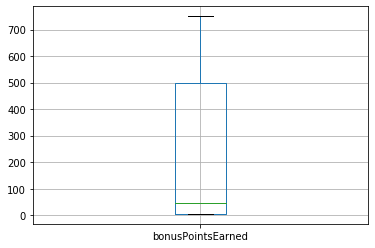

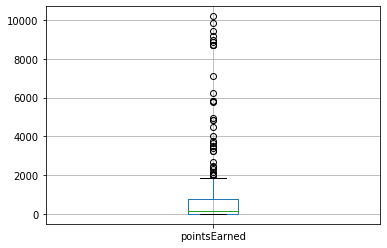

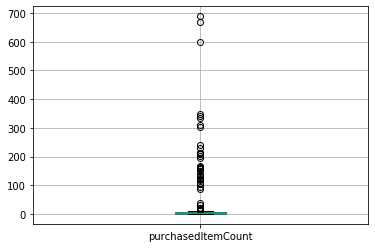

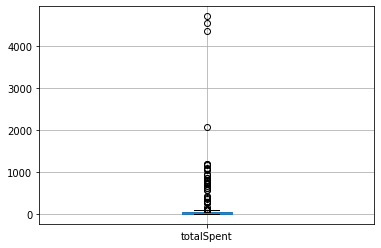

In [367]:
#Change pointsEarned and totalSpent to float
receipts_new["pointsEarned"] = receipts_new.pointsEarned.astype(float)
receipts_new["totalSpent"] = receipts_new.totalSpent.astype(float)

#Create DF of only the Columns I want to Analyze
outlier_check = receipts_new[['bonusPointsEarned','pointsEarned','purchasedItemCount','totalSpent']]

#Import matplotlib.pyplot to Create Charts
import matplotlib.pyplot as plt

#Create a Box and Whisker Plot for each of the Columns
for column in outlier_check:
    plt.figure()
    outlier_check.boxplot([column])
    
#There are outliers in all columns except for bonusPointsEarned

### Check for Duplicated IDs in Brands and Users

In [420]:
#There are duplicated userids
lists = users_new[users_new.duplicated(['_id'])]['_id'].to_list()
users_new[users_new._id.isin(lists)].sort_values(by=['_id'])

,active,role,signUpSource,state,_id,createdDate,lastLogin
494,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204
475,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204
476,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204
477,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204
478,True,fetch-staff,NaN,NaN,54943462e4b07e684157a532,2014-12-19 14:21:22.381,2021-03-05 16:52:23.204
...,...,...,...,...,...,...,...
365,True,consumer,Email,WI,60189c94c8b50e11d8454f6b,2021-02-02 00:28:04.020,2021-02-02 00:28:04.073
387,True,consumer,Email,WI,601c2c05969c0b11f7d0b097,2021-02-04 17:16:53.700,2021-02-04 17:20:30.228
385,True,consumer,Email,WI,601c2c05969c0b11f7d0b097,2021-02-04 17:16:53.700,2021-02-04 17:20:30.228
394,True,consumer,Email,WI,60229990b57b8a12187fe9e0,2021-02-09 14:17:52.581,2021-02-09 14:17:52.626


In [421]:
##Check for Duplicates in Brand 
#There are duplications of barcode which means that there are multiple brand names to each barcode
lists = brands_new[brands_new.duplicated(['barcode'])]['barcode'].to_list()
brands_new[brands_new.barcode.isin(lists)].sort_values(by=['barcode'])

,barcode,category,categoryCode,name,topBrand,_id,cpg.$id.$oid,cpg,brandCode
467,511111004790,Baking,NaN,alexa,True,5c409ab4cd244a3539b84162,55b62995e4b0d8e685c14213,Cogs,ALEXA
1071,511111004790,Condiments & Sauces,NaN,Bitten Dressing,NaN,5cdacd63166eb33eb7ce0fa8,559c2234e4b06aca36af13c6,Cogs,BITTEN
152,511111204923,Grocery,NaN,Brand1,True,5c45f91b87ff3552f950f027,5c45f8b087ff3552f950f026,Cogs,0987654321
536,511111204923,Snacks,NaN,CHESTER'S,NaN,5d6027f46d5f3b23d1bc7906,5332f5fbe4b03c9a25efd0ba,Cogs,CHESTERS
20,511111305125,Baby,NaN,Chris Image Test,NaN,5c4699f387ff3577e203ea29,55b62995e4b0d8e685c14213,Cogs,CHRISIMAGE
651,511111305125,Magazines,NaN,Rachael Ray Everyday,NaN,5d642d65a3a018514994f42d,5d5d4fd16d5f3b23d1bc7905,Cogs,511111305125
129,511111504139,Beverages,NaN,Chris Brand XYZ,NaN,5a7e0604e4b0aedb3b84afd3,55b62995e4b0d8e685c14213,Cogs,CHRISXYZ
299,511111504139,Grocery,NaN,Pace,False,5a8c33f3e4b07f0a2dac8943,5a734034e4b0d58f376be874,Cogs,PACE
9,511111504788,Baking,NaN,test,NaN,5c408e8bcd244a1fdb47aee7,59ba6f1ce4b092b29c167346,Cogs,TEST
412,511111504788,Condiments & Sauces,NaN,The Pioneer Woman,NaN,5ccb2ece166eb31bbbadccbe,559c2234e4b06aca36af13c6,Cogs,PIONEER WOMAN


### Check if there is a User ID in Users for each User in Receipts

In [423]:
#There are 148 IDS from the Receipts table that do not have an ID in the Users table
dup_users = receipts_new.merge(users_new, left_on='userId', right_on='_id', how='left')
dup_users._id_y.isnull().sum()

148

### Check if Difference in Barcode Types in Receipts and Users

In [427]:
#Look at unique barcode in Brands
brands_new.barcode.unique()

array(['511111019862', '511111519928', '511111819905', ...,
       '511111416173', '511111400608', '511111019930'], dtype=object)

In [428]:
#Look at Unique Barcodes in Receipts
receipts_explode.barcode.unique()


array(['4011', '028400642255', '', '1234', '046000832517', '013562300631',
       '034100573065', '075925306254', '041000168468', '2700719497082',
       '079400066619', '051500720011', '087684001127', '071040063102',
       '029000079236', '041129002292', '043000946060', '044700009888',
       '021000012961', '021000678358', '044700033302', '021000059232',
       '043000004944', '759283400082', '025800000135', '043000043486',
       '029000024748', '044700002810', '043000079904', '044000000745',
       '046704085905', '021000057832', '021000002917', '044700019917',
       '043000035818', '070085046583', '044700073377', '021000055920',
       '021000051885', '022174070214', '043000012871', '043000077467',
       '043000008836', '021000068364', '021000013869', '044700030479',
       '041258081601', '043000075821', '021000667543', '013120013966',
       '021000068760', '070277290107', '041129088005', '013000993906',
       '043000065198', '021000050765', '021000032778', '043000046814',
 